# Metric Exploration

I'd like to explore metric compression, summarisation, interpretation, visualisation, and storage.

## Percentage Byte-Encoding

In [26]:
import os
import random

def encode_percent(pct: float) -> int:
  return round(pct * 255)

ONE_DAY = 60 * 60 * 24

def percentages (n: int) -> list[float]:
  return [random.random() for _ in range(n)]

fpath = './1-byte-metrics.bin'

def write_percentages(n: int) -> list[float]:
  pcts = percentages(n)
  pcts_encoded = b''.join(
      [encode_percent(pct).to_bytes(1, 'little') for pct in pcts])

  with open(fpath, 'wb') as conn:
    conn.write(pcts_encoded)

  return pcts

def decode_percentages():
  with open(fpath, 'rb') as conn:
    while byte := conn.read(1):
      yield int.from_bytes(byte, 'little') / 256

before = write_percentages(ONE_DAY)
after = decode_percentages()

In [27]:
def get_encoded_size(fpath) -> dict:
  size = os.path.getsize(fpath)
  kb = size / 1e3
  mb = size / 1e6
  gb = size / 1e9

  return { 'bytes': size, 'kb': kb, 'mb': mb, 'gb': gb }

get_encoded_size(fpath)

{'bytes': 86400, 'kb': 86.4, 'mb': 0.0864, 'gb': 8.64e-05}

So we can store a day's worth of one-second data in 86kb of bytes, without much of a loss of fidelity ($< 0.5\%$). Assuming we store metadata about the metrics in a reasonable way; e.g we have a single dictionary entry containing the context of the  metrics, and we have no 'holes' in the time-series we need to account for how does this scale?

In [28]:
some_large_number_of_computers = 1_000_000
important_percentage_metrics = 20
retention_time = 60 * 60 * 24 * 325


total_bytes = some_large_number_of_computers * important_percentage_metrics * retention_time
terabytes = total_bytes / 1e12
{ 'tb': terabytes}


{'tb': 561.6}

So a million computers, each logging 20 percentage-metrics each second, retained for a year, can theoretically fit within half a petabyte of storage. This is without compression. Not terrible!

How well does a real metric compress? We'll try with plain old gzip

In [29]:
import json
from pathlib import Path
import gzip
import shutil

def read_cpu():
  cpu = json.load(open('./cpu.json'))
  return cpu['sysstat']['hosts'][0]['statistics']

def transform_cpu():
  for snapshot in read_cpu():
    for cpu in snapshot['cpu-load']:
      cpu_id = cpu['cpu']

      for metric, value in cpu.items():
        if metric == 'cpu':
          continue

        yield {
          'cpu_id': cpu_id,
          'metric': metric,
          'value': encode_percent(value / 100).to_bytes(1, 'little')
        }

def write_cpu_by_cpu_metric():
  default = list[bytes]
  groups = {}

  for data in transform_cpu():
    group = data['cpu_id'] + '_' + data['metric']

    if not group in groups:
      groups[group] = []

    groups[group].append(data['value'])

  for prefix, values in groups.items():
    fpath = Path('./cpu_1_byte') / Path(prefix)
    with open(fpath, 'wb') as conn:
      conn.write(b''.join(values))


def compress_cpu_1_byte_metrics():
  for fpath in os.listdir('./cpu_1_byte'):
    if not fpath.endswith('gz'):
      src = Path('./cpu_1_byte') / Path(fpath)
      tgt = Path('./cpu_1_byte') / Path(fpath + '.gz')

      with open(src, 'rb') as conn_in:
        with gzip.open(tgt, 'wb') as conn_out:
          shutil.copyfileobj(conn_in, conn_out)      

write_cpu_by_cpu_metric()
compress_cpu_1_byte_metrics()


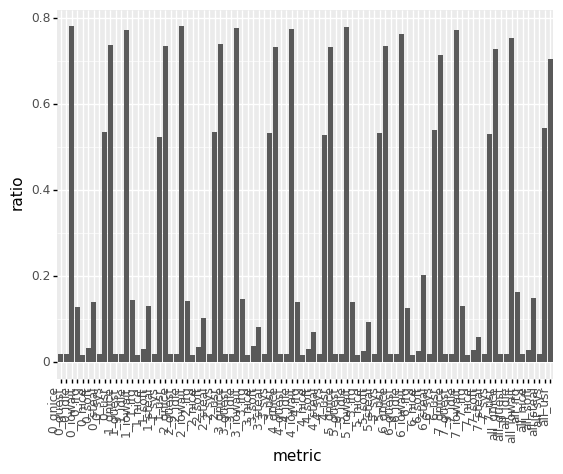

<ggplot: (8757940003425)>

In [37]:
import plotnine as p9
import pandas

def plot_compression_ratios():
  rows = []

  for fpath in os.listdir('./cpu_1_byte'):
    if fpath.endswith('gz'):
     continue

    before = get_encoded_size(os.path.join('./cpu_1_byte/', fpath))
    after = get_encoded_size(os.path.join('./cpu_1_byte/', fpath + '.gz'))

    rows.append([
      fpath,
      after['bytes'] / before['bytes'] 
    ])

  return pandas.DataFrame(rows, columns=['metric', 'ratio'])
  

df = plot_compression_ratios()

In [40]:
df['ratio'].describe()

count    90.000000
mean      0.239718
std       0.297894
min       0.017917
25%       0.018750
50%       0.048542
75%       0.533646
max       0.780833
Name: ratio, dtype: float64

For this set of metrics, we can get a further compression of x0.24